# Full Power Condenser Fault Detection

This is a simple AutoKeras model to exhibit the effectiveness of modeling fault detection within reactors. Time series and regression models were used to determine what goes into creating a fault. This is a preliminary model which will be reevaluated and redone for both the steam generator and the condenser at multiple powers. Currently, this system is looking at full power condenser faults.

In [1]:
# Change runtime to GPU!

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import autokeras as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

## Data preprocessing and pruning

In [2]:
full_100_run = pd.read_csv('https://gitlab.com/lambpati/asherah-training/-/raw/main/AS1.0.100_1.csv')
fault_100_run = pd.read_csv('https://gitlab.com/lambpati/asherah-training/-/raw/main/condenser80power100.csv')

In [3]:
full_100_run.head()

AF_LetdownFlow  AF_LetdownValvePos  AF_MakeupFLow  AF_MakeupValvePos  \
0             0.0                 0.0              0                  0   
1             0.0                 0.0              0                  0   
2             0.0                 0.0              0                  0   
3             0.0                 0.0              0                  0   
4             0.0                 0.0              0                  0   

     CC_PumpFlow  CC_PumpInletTemp  CC_PumpOutletTemp  CC_PumpSpeed  \
0  168320.000000            298.15         302.680000    100.000000   
1  168320.000000            298.15         302.678077    100.000000   
2  168342.876068            298.15         302.676769    100.013591   
3  168380.560738            298.15         302.675881    100.035980   
4  168427.497299            298.15         302.675276    100.063865   

   CC_PumpTemp  CD_CondTemp  ...  SG2_OutletSteamTemp  SG2_OutletTemp  \
0       333.15   306.458247  ...           553.083239      562.386235   
1       333.15   306.547639  ...           553.083232      562.728670   
2       333.15   306.609082  ...           553.081801      562.702210   
3       333.15   306.651090  ...           553.079406      562.614108   
4       333.15   306.679606  ...           553.076155      562.724770   

      SG2_Press  SG2_SteamT  SG2_WaterTemp  TB_InSteamFlow  TB_InSteamPress  \
0  6.410000e+06  553.083239     553.083239     1522.220000     6.410000e+06   
1  6.409999e+06  553.083232     553.083232     1522.216688     6.409999e+06   
2  6.409861e+06  553.081801     553.081801     1522.197916     6.409861e+06   
3  6.409629e+06  553.079406     553.079406     1522.147707     6.409629e+06   
4  6.409315e+06  553.076155     553.076155     1522.054938     6.409315e+06   

   TB_OutSteamPress    TB_Speed  TB_SpeedCtrlValvePos  
0       5199.600000  157.079633            100.000000  
1       5226.781640  157.079633             99.999931  
2       5245.464677  157.079633             99.986090  
3       5258.238118  157.079633             99.962880  
4       5266.909097  157.079633             99.931316  

[5 rows x 95 columns]

In [4]:
# Prune full dataset to just condenser values
condenser = full_100_run#[['CD_CondTemp', 'CD_InSteamFlow', 'CD_Level', 'CD_OutCondFlow', 'CD_Press', 'CD_SteamTemp']]

In [5]:
# Set all values from full dataset to 'True' for steadystate
condenser = condenser.assign(Steady = 1)

In [6]:
# Prune fault dataset to just condenser values
fault_cond = fault_100_run#[['CD_CondTemp', 'CD_InSteamFlow', 'CD_Level', 'CD_OutCondFlow', 'CD_Press', 'CD_SteamTemp']]

In [7]:
# Set all values from fault data set to 'False' for steadystate 
fault_cond = fault_cond.assign(Steady = 0)

In [8]:
# Concat the steady data with fault data
df = pd.concat([condenser, fault_cond])
df.shape

(57714, 97)

In [9]:
# Check to make sure true values still exist
True in df['Steady']

True

In [10]:
# Check to make sure false values still exist
False in df['Steady']

True

In [11]:
# Strip units
df['Time'] = df['Time'].str.replace(r'\D', '') 

In [12]:
# Check to make sure there are no NaN values
df.isnull().values.any()
df.dropna()

AF_LetdownFlow  AF_LetdownValvePos  AF_MakeupFLow  AF_MakeupValvePos  \
0                 0.0                 0.0              0           0.000000   
1                 0.0                 0.0              0           0.000000   
2                 0.0                 0.0              0           0.000000   
3                 0.0                 0.0              0           0.000000   
4                 0.0                 0.0              0           0.000000   
...               ...                 ...            ...                ...   
51093             0.0                 0.0              0          97.241909   
51094             0.0                 0.0              0          97.244122   
51095             0.0                 0.0              0          97.246336   
51096             0.0                 0.0              0          97.248549   
51097             0.0                 0.0              0          97.250762   

         CC_PumpFlow  CC_PumpInletTemp  CC_PumpOutletTemp  CC_PumpSpeed  \
0      168320.000000            298.15         302.680000    100.000000   
1      168320.000000            298.15         302.678077    100.000000   
2      168342.876068            298.15         302.676769    100.013591   
3      168380.560738            298.15         302.675881    100.035980   
4      168427.497299            298.15         302.675276    100.063865   
...              ...               ...                ...           ...   
51093  172862.248959            298.15         302.487367    102.698579   
51094  172862.248957            298.15         302.487367    102.698579   
51095  172862.248955            298.15         302.487367    102.698579   
51096  172862.248954            298.15         302.487367    102.698579   
51097  172862.248952            298.15         302.487367    102.698579   

       CC_PumpTemp  CD_CondTemp  ...     SG2_Press  SG2_SteamT  SG2_WaterTemp  \
0           333.15   306.458247  ...  6.410000e+06  553.083239     553.083239   
1           333.15   306.547639  ...  6.409999e+06  553.083232     553.083232   
2           333.15   306.609082  ...  6.409861e+06  553.081801     553.081801   
3           333.15   306.651090  ...  6.409629e+06  553.079406     553.079406   
4           333.15   306.679606  ...  6.409315e+06  553.076155     553.076155   
...            ...          ...  ...           ...         ...            ...   
51093       333.15   306.458247  ...  6.410000e+06  553.083239     553.083239   
51094       333.15   306.458247  ...  6.410000e+06  553.083239     553.083239   
51095       333.15   306.458247  ...  6.410000e+06  553.083239     553.083239   
51096       333.15   306.458247  ...  6.410000e+06  553.083239     553.083239   
51097       333.15   306.458247  ...  6.410000e+06  553.083239     553.083239   

       TB_InSteamFlow  TB_InSteamPress  TB_OutSteamPress    TB_Speed  \
0         1522.220000     6.410000e+06       5199.600000  157.079633   
1         1522.216688     6.409999e+06       5226.781640  157.079633   
2         1522.197916     6.409861e+06       5245.464677  157.079633   
3         1522.147707     6.409629e+06       5258.238118  157.079633   
4         1522.054938     6.409315e+06       5266.909097  157.079633   
...               ...              ...               ...         ...   
51093     1490.277803     6.410000e+06       5199.599989  157.079633   
51094     1490.277803     6.410000e+06       5199.599989  157.079633   
51095     1490.277803     6.410000e+06       5199.599989  157.079633   
51096     1490.277803     6.410000e+06       5199.599989  157.079633   
51097     1490.277803     6.410000e+06       5199.599989  157.079633   

       TB_SpeedCtrlValvePos  Steady   Time  
0                100.000000       0      0  
1                 99.999931       0     01  
2                 99.986090       0     02  
3                 99.962880       0     03  
4                 99.931316       0     04  
...                     ...     ...    ...  
5109

In [13]:
# Make target if system is steady state or not
target = df[['Steady']]

In [14]:
# Drop 'Steady' for dataframe
df = df.drop(['Steady'],axis=1)

## Create an RNN for fault detection (wrt time)

In [15]:
# Split data into training, testing, and validation
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=1/5)
X_train_tr, X_train_v, y_train_tr, y_train_v = train_test_split(X_train, y_train, test_size=1/10)

In [16]:
# Scale data for keras
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
data_X = X_train_tr[:].astype("float64")
data_X_v = X_train_v[:].astype("float64")
data_y = y_train_tr[:].astype("float64")
data_y_v = y_train_v[:].astype("float64")
data_X_test = X_test[:].astype("float64")
data_y_test = y_test[:].astype("float64")

In [17]:
predict_from = 1
predict_until = 10
lookback = 3
clf = ak.TimeseriesForecaster(
    lookback=lookback,
    predict_from=predict_from,
    predict_until=predict_until,
    max_trials=10,
    objective="val_loss",
)
# Train the TimeSeriesForecaster with train data
history = clf.fit(
    x=data_X,
    y=data_y,
    validation_data=(data_X_v, data_y_v),
    batch_size=32,
    epochs=100,
)
# Predict with the best model(includes original training data).
samples = np.array(data_X_test)
# predictions = clf.predict(samples)

# print(predictions.shape)

Trial 10 Complete [00h 02m 04s]
val_loss: 0.09817091375589371

Best val_loss So Far: 0.09810943156480789
Total elapsed time: 00h 20m 56s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
1299/1299 [==============================] - 14s 8ms/step - loss: 0.1040 - mean_squared_error: 0.1040 - val_loss: 0.0983 - val_mean_squared_error: 0.0983
Epoch 2/100
1299/1299 [==============================] - 10s 8ms/step - loss: 0.1022 - mean_squared_error: 0.1022 - val_loss: 0.0982 - val_mean_squared_error: 0.0982
Epoch 3/100
1299/1299 [==============================] - 10s 8ms/step - loss: 0.1018 - mean_squared_error: 0.1018 - val_loss: 0.0981 - val_mean_squared_error: 0.0981
Epoch 4/100
1299/1299 [==============================] - 10s 8ms/step - loss: 0.1017 - mean_squared_error: 0.1017 - val_loss: 0.0981 - val_mean_squared_error: 0.0981
Epoch 5/100
1299/1299 [==============================] - 10s 8ms/step - loss: 0.1016 - mean_squared_error: 0.1016 - val_loss: 0.0981 - val_mean_squared_error: 0.

1299/1299 [==============================] - 10s 8ms/step - loss: 0.1015 - mean_squared_error: 0.1015 - val_loss: 0.0981 - val_mean_squared_error: 0.0981
Epoch 50/100
1299/1299 [==============================] - 10s 8ms/step - loss: 0.1015 - mean_squared_error: 0.1015 - val_loss: 0.0981 - val_mean_squared_error: 0.0981
Epoch 51/100
1299/1299 [==============================] - 10s 8ms/step - loss: 0.1015 - mean_squared_error: 0.1015 - val_loss: 0.0981 - val_mean_squared_error: 0.0981
Epoch 52/100
1299/1299 [==============================] - 10s 8ms/step - loss: 0.1015 - mean_squared_error: 0.1015 - val_loss: 0.0981 - val_mean_squared_error: 0.0981
Epoch 53/100
1299/1299 [==============================] - 10s 8ms/step - loss: 0.1015 - mean_squared_error: 0.1015 - val_loss: 0.0981 - val_mean_squared_error: 0.0981
Epoch 54/100
1299/1299 [==============================] - 10s 8ms/step - loss: 0.1015 - mean_squared_error: 0.1015 - val_loss: 0.0981 - val_mean_squared_error: 0.0981
Epoch 55/10

INFO:tensorflow:Assets written to: ./time_series_forecaster/best_model/assets


INFO:tensorflow:Assets written to: ./time_series_forecaster/best_model/assets


In [18]:
# Evaluate the best model with testing data.
clf.evaluate(data_X_test, data_y_test)

361/361 [==============================] - 2s 4ms/step - loss: 0.1029 - mean_squared_error: 0.1029


[0.10289832204580307, 0.10289832204580307]

## Create a ANN for fault detection

In [19]:
# Drop time
df = df.drop(['Time'],axis=1)

In [20]:
# Split data into training, testing, and validation
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=1/5)
# X_train_tr, X_train_v, y_train_tr, y_train_v = train_test_split(X_train, y_train, test_size=1/10)

In [21]:
# Try StructuredDataRegressor
# It tries 10 different models.
reg = ak.StructuredDataRegressor(max_trials=10, overwrite=True)
# Feed the structured data regressor with training data.
history = reg.fit(X_train, y_train, epochs=100)
# Predict with the best model.
predicted_y = reg.predict(X_test)

Trial 10 Complete [00h 01m 50s]
val_loss: 0.05877861753106117

Best val_loss So Far: 0.05874379724264145
Total elapsed time: 00h 14m 57s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.0676 - mean_squared_error: 0.0676
Epoch 2/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.0617 - mean_squared_error: 0.0617
Epoch 3/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.0594 - mean_squared_error: 0.0594
Epoch 4/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.0597 - mean_squared_error: 0.0597
Epoch 5/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.0587 - mean_squared_error: 0.0587
Epoch 6/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.0585 - mean_squared_error: 0.0585
Epoch 7/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.0582 - mean_squared_error: 0.0582
Epoch 8/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.0581 - mean_squared_error: 0.0581
Epoch 9/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.0581 - mean_squar

INFO:tensorflow:Assets written to: ./structured_data_regressor/best_model/assets


361/361 [==============================] - 1s 2ms/step


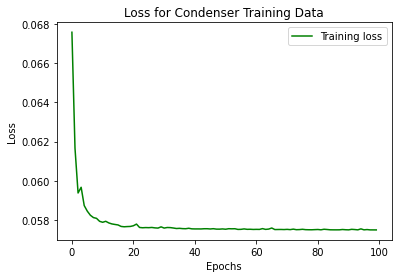

In [70]:
# Plot the best fitting model
plt.plot(history.epoch, history.history["loss"], 'g', label="Training loss")
plt.title('Loss for Condenser Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
# Evaluate the best model with testing data.
reg.evaluate(X_test, y_test)

361/361 [==============================] - 1s 1ms/step - loss: 0.0572 - mean_squared_error: 0.0572


[0.057204488664865494, 0.057204488664865494]

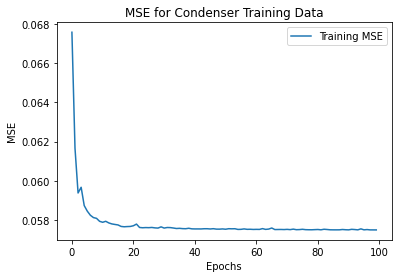

In [69]:
# Plot history: MSE
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.title('MSE for Condenser Training Data')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## Classification

In [24]:
# Split data into training, testing, and validation
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=1/5)

In [25]:
# It tries 10 different models.
clf = ak.StructuredDataClassifier(overwrite=True, max_trials=10)
# Feed the structured data classifier with training data.
clf.fit(X_train, y_train, epochs=100)
# Predict with the best model.
predicted_y = clf.predict(X_test)


Trial 10 Complete [00h 02m 42s]
val_accuracy: 0.888394296169281

Best val_accuracy So Far: 0.8888285756111145
Total elapsed time: 00h 22m 38s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.1788 - accuracy: 0.8836
Epoch 2/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.1612 - accuracy: 0.8846
Epoch 3/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.1605 - accuracy: 0.8853
Epoch 4/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.1603 - accuracy: 0.8840
Epoch 5/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.1600 - accuracy: 0.8852
Epoch 6/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.1600 - accuracy: 0.8853
Epoch 7/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.1598 - accuracy: 0.8860
Epoch 8/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.1598 - accuracy: 0.8857
Epoch 9/100
1443/1443 [==============================] - 3s 2ms/step - loss: 0.1597 - accuracy: 0.8863
Epoch 10/100
1443/1443 [==============================] - 3s 2ms/step - l

INFO:tensorflow:Assets written to: ./structured_data_classifier/best_model/assets


361/361 [==============================] - 1s 2ms/step


In [26]:
clf.evaluate(X_test, y_test)

361/361 [==============================] - 1s 2ms/step - loss: 0.1605 - accuracy: 0.8861


[0.16050127148628235, 0.8860781192779541]

In [ ]:
plt.plot(y_test, predicted_y)00

## Evaluation

Considering the Regression model did better than the time series model, fault detection will be modeled as a regression instead of time series. The next step is pruning the data even more to reduce the mean squared error.